In [2]:
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge

In [21]:
# Load data
df = pd.read_csv('vehicles.csv')

In [22]:
# Describe Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [43]:
# Explore Data
df.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

(array([1880., 1900., 1920., 1940., 1960., 1980., 2000., 2020., 2040.]),
 [Text(1880.0, 0, '1880'),
  Text(1900.0, 0, '1900'),
  Text(1920.0, 0, '1920'),
  Text(1940.0, 0, '1940'),
  Text(1960.0, 0, '1960'),
  Text(1980.0, 0, '1980'),
  Text(2000.0, 0, '2000'),
  Text(2020.0, 0, '2020'),
  Text(2040.0, 0, '2040')])

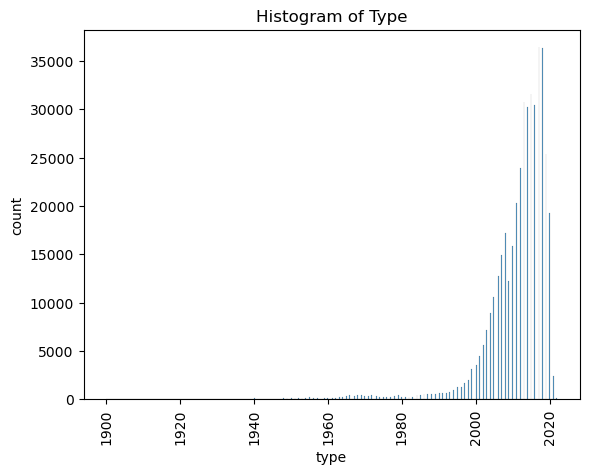

In [45]:
# Complete histogram to check for low variance across columns
sns.histplot(df['year'])
plt.xlabel('type')
plt.ylabel('count')
plt.title('Histogram of Type')
plt.xticks(rotation=90)
##plt.savefig('typehist.png')

In [47]:
# Calculate missing data %
missing_percentage = df.isnull().sum() / len(df) * 100
print(missing_percentage)

id               0.000000
region           0.000000
price            0.000000
year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
state            0.000000
dtype: float64


In [49]:
# Data Preparation

df1 = df[['price']].query('price > 1000')

dfp = df1['price']

Q1 = np.percentile(dfp, 25)
Q2 = np.percentile(dfp, 50)
Q3 = np.percentile(dfp, 75)

IQR = Q3 - Q1

lw = Q1 - 1.5 * IQR
uw = Q3 + 1.5 * IQR

actual_min = dfp[dfp >= lw].min()
actual_max = dfp[dfp <= uw].max()

# Find outliers
outliers = dfp[(dfp < lw) | (dfp > uw)]

# Print results
print(f"Q1 (25th percentile): {Q1}")
print(f"Median (50th percentile): {Q2}")
print(f"Q3 (75th percentile): {Q3}")
print(f"IQR: {IQR}")
print(f"Lower whisker (not less than): {actual_min}")
print(f"Upper whisker (not more than): {actual_max}")
print(f"Number of outliers: {len(outliers)}")

Q1 (25th percentile): 7995.0
Median (50th percentile): 15995.0
Q3 (75th percentile): 27991.0
IQR: 19996.0
Lower whisker (not less than): 1002
Upper whisker (not more than): 57982
Number of outliers: 8008


In [51]:
df1[['price']].query('price > 57985')

,price
204,58977
280,987654321
346,98900
365,72900
461,99950
...,...
426694,59900
426716,65950
426778,65995
426810,58995


In [53]:
# Construct Data - remove outlier prices
cdf = df.query('price > 1000 and price < 57985')

In [55]:
# Drop unneeded columns

cdf1 = cdf.drop(['id', 'title_status', 'transmission', 'VIN', 'fuel', 'size','model'], axis = 1)
cdf1

,region,price,year,manufacturer,condition,cylinders,odometer,drive,type,paint_color,state
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
...,...,...,...,...,...,...,...,...,...,...,...
426875,wyoming,23590,2019.0,nissan,good,6 cylinders,32226.0,fwd,sedan,NaN,wy
426876,wyoming,30590,2020.0,volvo,good,NaN,12029.0,fwd,sedan,red,wy
426877,wyoming,34990,2020.0,cadillac,good,NaN,4174.0,NaN,hatchback,white,wy
426878,wyoming,28990,2018.0,lexus,good,6 cylinders,30112.0,fwd,sedan,silver,wy


In [57]:
# Drop rows where year is null

cdf2 = cdf1.dropna(subset = ['year'])


In [59]:
cdf3 = cdf2.query('year > 1990')
cdf3['year'] = cdf3['year'].astype(int)
cdf3

/var/folders/wl/swxg00192qzgkm_xpk6tkj_00000gn/T/ipykernel_66136/3832507532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf3['year'] = cdf3['year'].astype(int)


,region,price,year,manufacturer,condition,cylinders,odometer,drive,type,paint_color,state
27,auburn,33590,2014,gmc,good,8 cylinders,57923.0,NaN,pickup,white,al
28,auburn,22590,2010,chevrolet,good,8 cylinders,71229.0,NaN,pickup,blue,al
29,auburn,39590,2020,chevrolet,good,8 cylinders,19160.0,NaN,pickup,red,al
30,auburn,30990,2017,toyota,good,8 cylinders,41124.0,NaN,pickup,red,al
31,auburn,15000,2013,ford,excellent,6 cylinders,128000.0,rwd,truck,black,al
...,...,...,...,...,...,...,...,...,...,...,...
426875,wyoming,23590,2019,nissan,good,6 cylinders,32226.0,fwd,sedan,NaN,wy
426876,wyoming,30590,2020,volvo,good,NaN,12029.0,fwd,sedan,red,wy
426877,wyoming,34990,2020,cadillac,good,NaN,4174.0,NaN,hatchback,white,wy
426878,wyoming,28990,2018,lexus,good,6 cylinders,30112.0,fwd,sedan,silver,wy


In [61]:
cdf3['condition'] = cdf3['condition'].fillna('fair')


/var/folders/wl/swxg00192qzgkm_xpk6tkj_00000gn/T/ipykernel_66136/76690192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf3['condition'] = cdf3['condition'].fillna('fair')


In [63]:
cdf4 = cdf3.reset_index(drop = True)
cdf4

,region,price,year,manufacturer,condition,cylinders,odometer,drive,type,paint_color,state
0,auburn,33590,2014,gmc,good,8 cylinders,57923.0,NaN,pickup,white,al
1,auburn,22590,2010,chevrolet,good,8 cylinders,71229.0,NaN,pickup,blue,al
2,auburn,39590,2020,chevrolet,good,8 cylinders,19160.0,NaN,pickup,red,al
3,auburn,30990,2017,toyota,good,8 cylinders,41124.0,NaN,pickup,red,al
4,auburn,15000,2013,ford,excellent,6 cylinders,128000.0,rwd,truck,black,al
...,...,...,...,...,...,...,...,...,...,...,...
358535,wyoming,23590,2019,nissan,good,6 cylinders,32226.0,fwd,sedan,NaN,wy
358536,wyoming,30590,2020,volvo,good,NaN,12029.0,fwd,sedan,red,wy
358537,wyoming,34990,2020,cadillac,good,NaN,4174.0,NaN,hatchback,white,wy
358538,wyoming,28990,2018,lexus,good,6 cylinders,30112.0,fwd,sedan,silver,wy


In [65]:
# Delete cylinders from column, replace other and null values with average cyclinder count

cylinders = ['8 cylinders', '6 cylinders', np.nan, '4 cylinders', '5 cylinders',
             '3 cylinders', '10 cylinders', '12 cylinders', 'other']

cleaned = cylinders.copy()

for i, val in enumerate(cleaned):
    if isinstance(val, str) and 'cylinders' in val:
       
        cleaned[i] = int(val.split()[0])
    else:
  
        cleaned[i] = val

def clean_cylinders(val):
    if isinstance(val, str) and 'cylinders' in val:
        return int(val.split()[0])
    else:
        return val

cdf4['cylinders'] = cdf4['cylinders'].apply(clean_cylinders)

cdf4['cylinders'] = cdf4['cylinders'].replace('other', np.nan)

mean_cylinders = cdf4['cylinders'].astype(float).mean()

cdf4['cylinders'] = cdf4['cylinders'].fillna(round(mean_cylinders))

cdf4['cylinders'] = cdf4['cylinders'].astype(int)

/var/folders/wl/swxg00192qzgkm_xpk6tkj_00000gn/T/ipykernel_66136/1272213094.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cdf4['cylinders'] = cdf4['cylinders'].replace('other', np.nan)


In [67]:


avg_od = cdf4.groupby('year')['odometer'].transform('mean')

cdf5 = cdf4

cdf5['odometer'] = cdf5['odometer'].fillna(avg_od)
cdf5

,region,price,year,manufacturer,condition,cylinders,odometer,drive,type,paint_color,state
0,auburn,33590,2014,gmc,good,8,57923.0,NaN,pickup,white,al
1,auburn,22590,2010,chevrolet,good,8,71229.0,NaN,pickup,blue,al
2,auburn,39590,2020,chevrolet,good,8,19160.0,NaN,pickup,red,al
3,auburn,30990,2017,toyota,good,8,41124.0,NaN,pickup,red,al
4,auburn,15000,2013,ford,excellent,6,128000.0,rwd,truck,black,al
...,...,...,...,...,...,...,...,...,...,...,...
358535,wyoming,23590,2019,nissan,good,6,32226.0,fwd,sedan,NaN,wy
358536,wyoming,30590,2020,volvo,good,6,12029.0,fwd,sedan,red,wy
358537,wyoming,34990,2020,cadillac,good,6,4174.0,NaN,hatchback,white,wy
358538,wyoming,28990,2018,lexus,good,6,30112.0,fwd,sedan,silver,wy


In [69]:
# Fill null values with unknown

cdf6 = cdf5
cdf6['manufacturer'] = cdf6['manufacturer'].fillna('unknown')
cdf6['drive'] = cdf6['drive'].fillna('unknown')
cdf6['type'] = cdf6['type'].fillna('unknown')
cdf6['paint_color'] = cdf6['paint_color'].fillna('unknown')
cdf6.isnull().sum()

region          0
price           0
year            0
manufacturer    0
condition       0
cylinders       0
odometer        0
drive           0
type            0
paint_color     0
state           0
dtype: int64

In [71]:
# Create new column using z-score scaling

cdf6['odometer_standardized'] = (cdf6['odometer'] - cdf6['odometer'].mean()) / cdf6['odometer'].std()
cdf6.head()

,region,price,year,manufacturer,condition,cylinders,odometer,drive,type,paint_color,state,odometer_standardized
0,auburn,33590,2014,gmc,good,8,57923.0,unknown,pickup,white,al,-0.308339
1,auburn,22590,2010,chevrolet,good,8,71229.0,unknown,pickup,blue,al,-0.205587
2,auburn,39590,2020,chevrolet,good,8,19160.0,unknown,pickup,red,al,-0.607674
3,auburn,30990,2017,toyota,good,8,41124.0,unknown,pickup,red,al,-0.438064
4,auburn,15000,2013,ford,excellent,6,128000.0,rwd,truck,black,al,0.232810


In [73]:
# Randomize the rows in the data set

cdf7 = cdf6.sample(frac = 1, random_state = 42).reset_index(drop = True)

##### Model

In [77]:
# Drop unneeded categorical features

cdf7 = cdf7.drop(['region','state','manufacturer','paint_color', 'condition', 'type'], axis=1)

In [79]:
# Applying one-hot encoding
df_encoded = pd.get_dummies(cdf7, columns=[ 'drive'])
df_encoded = df_encoded.fillna(0)
df_encoded = df_encoded.astype(int)
df_encoded.sample(5)

,price,year,cylinders,odometer,odometer_standardized,drive_4wd,drive_fwd,drive_rwd,drive_unknown
151009,3200,2008,6,143000,0,0,1,0,0
169355,23990,2017,6,28565,0,0,1,0,0
62461,16995,2016,8,200542,0,0,0,0,1
106541,25990,2017,6,29170,0,0,0,0,1
346600,22990,2019,6,11251,0,0,1,0,0


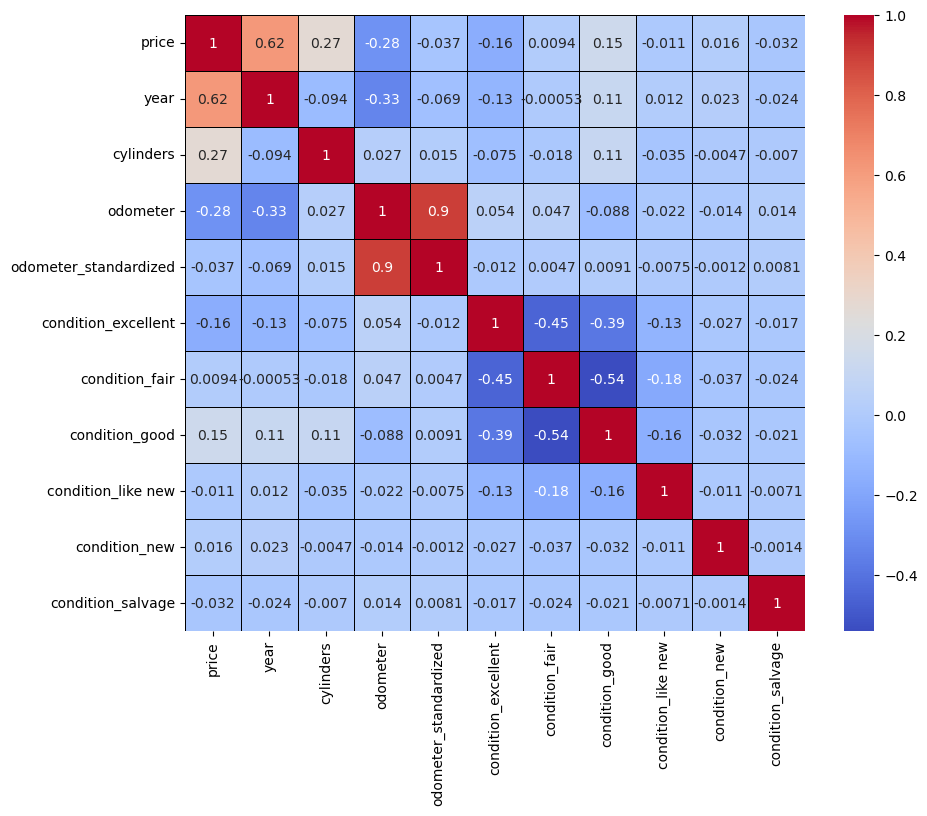

In [168]:
# Calculate the correlation matrix for the smaller DataFrame
corr = df_encoded.corr()

# Generate the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr,annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black',
            xticklabels=corr.columns, yticklabels=corr.columns)  # Consider turning off annotations for speed
plt.show()

In [81]:
# separate data into target & independent variables
x = df_encoded.drop(['price'], axis=1)
y = df_encoded['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=0)


In [96]:
# Model 1 Identify optimal degree

train_mses = []
test_mses = []
for i in range(1, 5):
    pipe = Pipeline([('pfeat', PolynomialFeatures(degree = i, include_bias=False)),
                    ('linreg', LinearRegression())])
    pipe.fit(x_train, y_train)
    train_preds = pipe.predict(x_train)
    test_preds = pipe.predict(x_test)
    train_mses.append(mean_squared_error(y_train, train_preds))
    test_mses.append(mean_squared_error(y_test, test_preds))

best_model_complexity = test_mses.index(min(test_mses)) + 1

In [98]:
# Check errors

print(train_mses)
print(test_mses)

[65296199.92913326]
[65280454.96140909]


The Complexity that minimized Test Error was: 2


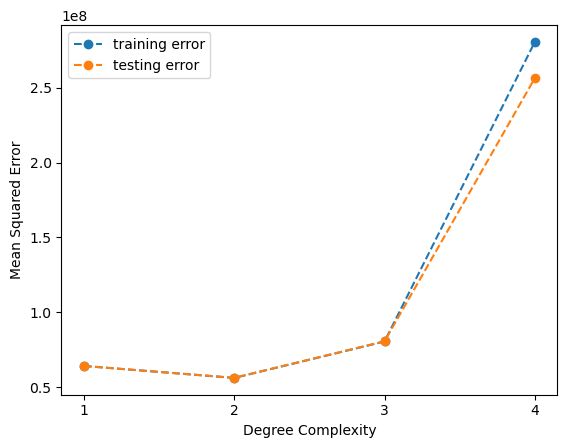

In [70]:
# Identify optimal degree

print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
plt.plot(range(1, 5), train_mses, '--o', label = 'training error')
plt.plot(range(1, 5), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, 5), range(1, 5))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

In [100]:
# Identify hyperparameters.

print(pipe.named_steps['linreg'].coef_)    # array of coefficients
print(pipe.named_steps['linreg'].intercept_)  # intercept (float)

[-2.32147039e+05 -3.17694517e+05 -3.65889700e-01  1.10478917e+05
  1.47417046e+03 -2.32835414e+05 -2.42020190e+04 -5.54321504e+03
  1.23717058e+05  1.37389420e+05  5.68025876e+01  1.85796611e+02
  1.76702676e-04 -5.56606119e+01  3.71082521e+03  3.94579564e+03
  3.73873782e+03  3.71875205e+03  3.59149025e+03  3.57437385e+03
 -4.76308342e+01  5.27474739e-03 -1.33505778e+03 -5.22294740e+04
 -5.28521022e+04 -5.30286621e+04 -5.24839049e+04 -5.32080078e+04
 -5.41171001e+04  1.53262590e-07 -3.76662018e-02 -9.86742424e-02
 -9.39042846e-02 -1.02297129e-01 -1.05841014e-01 -9.90407610e-02
 -4.40269063e-02  2.30402452e+03  1.98213959e+04  1.88915624e+04
  1.96285494e+04  2.05932966e+04  1.87388831e+04  1.28052294e+04
  1.47416882e+03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.32835414e+05  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.42020188e+04
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.54321479e+03
  0.00000000e+00  0.00000

In [108]:
# Model 2 Sequential Feature Selector Model

from sklearn.feature_selection import SequentialFeatureSelector

train_idx = x_train.index.to_list()
test_idx = x_test.index.to_list()

selector = SequentialFeatureSelector(estimator=LinearRegression(),
                                    n_features_to_select=8,
                                    cv = [[train_idx, test_idx]],
                                     n_jobs=-1,
                                    scoring = 'neg_mean_squared_error')
Xt = selector.fit_transform(x, y)

In [110]:
# Identify Features

selected_columns = x.columns[selector.get_support()]
print("Selected features:", selected_columns.tolist())

Selected features: ['year', 'cylinders', 'odometer', 'odometer_standardized', 'condition_fair', 'condition_good', 'condition_new', 'condition_salvage']


In [112]:
# Calculate MSE

lr = LinearRegression().fit(Xt, y)
model_preds = lr.predict(Xt)
mse = mean_squared_error(y, model_preds)

print(mse)

71942030.1934888


In [116]:
y = cdf7['price']

x = cdf7.drop(['price','region','state','manufacturer','paint_color', 'type', 'drive','condition'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=0)

x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250977 entries, 5679 to 305711
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   year                   250977 non-null  int64  
 1   cylinders              250977 non-null  int64  
 2   odometer               250977 non-null  float64
 3   odometer_standardized  250977 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 9.6 MB


In [167]:


auto_pipe = Pipeline([('polyfeatures', PolynomialFeatures(degree = 3, include_bias = False)),
                      ('scaler', StandardScaler()),
                     ('lasso', Lasso(alpha = 1, random_state = 42))])
auto_pipe.fit(x_train, y_train)
print(auto_pipe.named_steps['lasso'].coef_)
print(auto_pipe.named_steps['lasso'].intercept_)

[-3.09241485e+03 -7.40026064e+01  3.66579924e+03  1.13226514e-09
  5.05129614e+03  2.54909966e+03 -2.36039526e+02 -0.00000000e+00
  1.31179165e+03 -1.87137202e+03 -0.00000000e+00  4.13082626e+03
  0.00000000e+00  0.00000000e+00  4.50262988e+03  1.66225399e+03
 -3.34086767e+03 -0.00000000e+00  1.36161971e+03 -2.10570714e+03
 -0.00000000e+00  3.89962368e+03  0.00000000e+00  0.00000000e+00
 -1.71563651e+03 -1.59877974e+03 -4.03135912e+02  5.80651212e+03
  6.08889186e+01  5.79303181e+01 -9.12618490e+03 -7.82626561e+01
 -7.85489478e+01 -7.88180214e+01]
18503.898289484903


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.294e+12, tolerance: 3.943e+09
  model = cd_fast.enet_coordinate_descent(


In [169]:
lasso_train_mse = mean_squared_error(y_train, auto_pipe.predict(x_train))
lasso_test_mse = mean_squared_error(y_test, auto_pipe.predict(x_test))
print(lasso_train_mse)
print(lasso_test_mse)

74718441.53049308
74554792.08311301


In [ ]:
### Ridge Regression

In [125]:
ridge_low_pipe = Pipeline([('poly_features', PolynomialFeatures(degree = 2, include_bias= False)), 
                     ('ridge_low', Ridge(alpha = 10))])
ridge_low_pipe.fit(x_train, y_train)
ridge_low_preds = ridge_low_pipe.predict(x_test)

lasso_train_mse = mean_squared_error(y_train, ridge_low_pipe.predict(x_train))
lasso_test_mse = mean_squared_error(y_test, ridge_low_pipe.predict(x_test))

print(lasso_train_mse)
print(lasso_test_mse)
print(ridge_low_pipe.named_steps['ridge_low'].coef_)
print(ridge_low_pipe.named_steps['ridge_low'].intercept_)


56325034.597411916
56332212.29284992
[-1.23901924e+05 -4.57032743e+04 -2.77981427e+01 -2.41765298e+03
 -1.65884995e+04  1.36789861e+04  3.76807267e+03 -8.58559781e+02
  3.87616263e+01  3.12332147e+01 -2.84055696e-04  3.11105545e+00
 -3.09591928e+04 -3.09900072e+04 -3.09776325e+04 -3.09772785e+04
 -1.87350689e+02 -1.16638863e-02  1.30345727e+03 -1.05938780e+04
 -1.24700599e+04 -1.17773517e+04 -1.08619761e+04  1.90092802e-07
 -4.38675612e-02  2.83294870e+01  2.83707683e+01  2.83443820e+01
  2.83513572e+01  2.48527295e+03  1.37498223e+03 -3.36016902e+03
  3.37563529e+02 -7.70029833e+02 -1.65884995e+04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.36789859e+04  0.00000000e+00
  0.00000000e+00  3.76807270e+03  0.00000000e+00 -8.58559756e+02]
154697567.28237697


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.67579e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
